# Intro to 4D-STEM data: strain

In this notebook we find the strain on a gold nanoplatelet sample.  

This data was simulated together with the gold nanoparticle dataset used in the basics 01-03 tutorial notebooks.  Here, we use the ellipticity and pixel size calibrations from notebook 03, then independently calibrate the origin and rotation for this dataset, before finally finding the strain.


### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Ben Savitzky (bhsavitzky@lbl.gov)
- Steve Zeltmann (steven.zeltmann@berkeley.edu)
- Stephanie Ribet (sribet@u.northwestern.edu)
- Alex Rakowski (arakowski@lbl.gov)
- Colin Ophus (clophus@lbl.gov)


Updated 11/1/2023, version 0.14.8

## Set up the environment

In [2]:
import time
import os

import py4DSTEM
from py4DSTEM.visualize import show
import matplotlib.pyplot as plt

py4DSTEM.__version__

'0.14.15'

---
# Download the tutorial data <a class="anchor" id="part_00"></a>

You can download the tutorial dataset here: (501 megabytes)
* [Simulated single crystal and polycrystalline gold](https://drive.google.com/file/d/1m-jfXnStFWq0jo_hPY-3OtYaO62wHP3A/view?usp=drive_link)

# Load data

Load
- the same datacube as in the previous notebook, and 
- the results from basics_02 (disk detection)

In [3]:
# Load the .dm4 file from a workspace on OMNI or XNAS, set filepath with 'filepath_data = "FILEPATH"'
# even better, use dirpath'' and 'filepath_data', this makes it easier to add more paths later

dirpath = "/fast/ws-tmp/g031362-data/high_pressure_torsion/lamC/ROI3/"

filepath_data = dirpath + 'COPL_Ni65Cu35_C_ROI3_240827_aper_50_conv_1.5_spot_6_CL_47_stepsize_10_r_x_178_r_y_186_GIF_512x512_preprocessed_unfiltered_no_bin.h5'
filepath_basics_01 = dirpath + 'analysis_basics_01.h5'
filepath_basics_02 = dirpath + 'analysis_basics_02.h5'
filepath_basics_03 = dirpath + 'analysis_basics_03.h5'

In [4]:
py4DSTEM.print_h5_tree( filepath_data )

/
|---dm_dataset_root
    |---dm_dataset




In [8]:
# Load the nanoplatelet datacube

datacube = py4DSTEM.read(
    filepath = filepath_data,
    datapath = 'dm_dataset_root/dm_dataset'
)

datacube

DataCube( A 4-dimensional array of shape (186, 178, 512, 512) called 'dm_dataset',
          with dimensions:

              Rx = [0,5,10,...] nm
              Ry = [0,5,10,...] nm
              Qx = [0.0,0.0072991721332073215,0.014598344266414643,...] A^-1
              Qy = [0.0,0.0072991721332073215,0.014598344266414643,...] A^-1
)

In [9]:
# Load the defocused CBED image

defocused_cbed = py4DSTEM.read(
    filepath = filepath_data,
    datapath = 'dm_dataset_root/dm_dataset'
)

defocused_cbed

DataCube( A 4-dimensional array of shape (186, 178, 512, 512) called 'dm_dataset',
          with dimensions:

              Rx = [0,5,10,...] nm
              Ry = [0,5,10,...] nm
              Qx = [0.0,0.0072991721332073215,0.014598344266414643,...] A^-1
              Qy = [0.0,0.0072991721332073215,0.014598344266414643,...] A^-1
)

In [10]:
# Load the prior analysis

basics_03 = py4DSTEM.read(
    filepath_basics_03
)

basics_03.tree()

Reading PointListArray: 100%|████████████████████████████| 33108/33108 [00:04<00:00, 6716.44PointList/s]

/
|---2Dhist_braggvectors_cal_s=8
|---braggvectors
|---probe


## Transfer calibrations

In [11]:
COPL_HPT = basics_03.tree('braggvectors')

COPL_HPT.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:       0.005
             R_pixel_size:       5
             Q_pixel_units:      A^-1
             R_pixel_units:      nm
             QR_flip:            False
             _root_treepath:     
             a:                  586.6972915499178
             b:                  579.7485386887054
             origin_meas_mask:   2D-array
             probe_semiangle:    9.379479520193339
             qx0:                2D-array
             qx0_mean:           253.9385904004459
             qx0_meas:           2D-array
             qx0_shift:          2D-array
             qy0:                2D-array
             qy0_mean:           253.29710703002038
             qy0_meas:           2D-array
             qy0_shift:          2D-array
             theta:              -1.094329280203596
)

In [12]:
datacube.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:     0.0072991721332073215
             R_pixel_size:     5
             Q_pixel_units:    A^-1
             R_pixel_units:    nm
             QR_flip:          False
             _root_treepath:   
)

In [13]:
datacube.calibration.set_Q_pixel_size( COPL_HPT.calibration.get_Q_pixel_size() )
datacube.calibration.set_Q_pixel_units( COPL_HPT.calibration.get_Q_pixel_units() )
datacube.calibration.set_ellipse( COPL_HPT.calibration.get_ellipse() )

datacube.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:     0.005
             R_pixel_size:     5
             Q_pixel_units:    A^-1
             R_pixel_units:    nm
             QR_flip:          False
             _root_treepath:   
             a:                586.6972915499178
             b:                579.7485386887054
             theta:            -1.094329280203596
)

# Basic visualizations

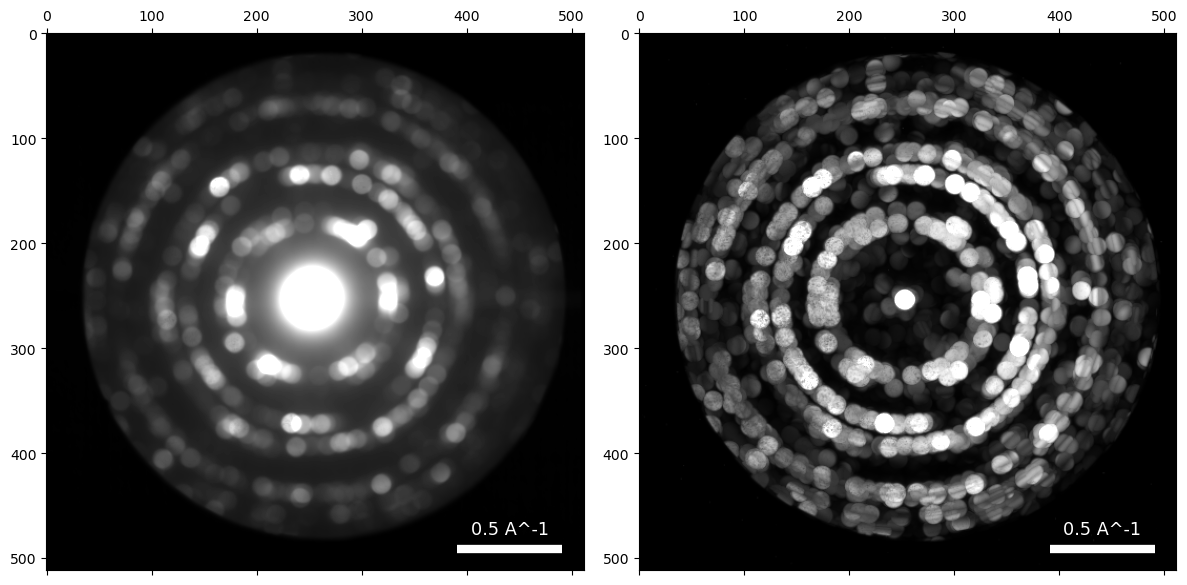

In [14]:
# mean + max diffraction

dp_mean = datacube.get_dp_mean()
dp_max = datacube.get_dp_max()

show(
    [dp_mean,dp_max]
)

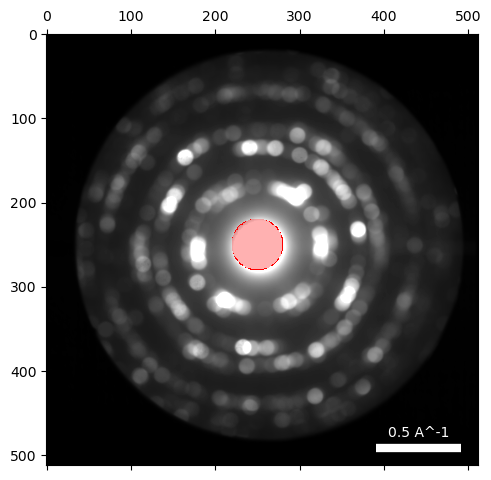

In [15]:
# virtual imaging - position detector

center = 250,250
radius = 30

datacube.position_detector(
    mode = 'circle',
    geometry = (center,radius)
)

100%|███████████████████████████████████████████████████████████| 33108/33108 [00:05<00:00, 5740.53it/s]


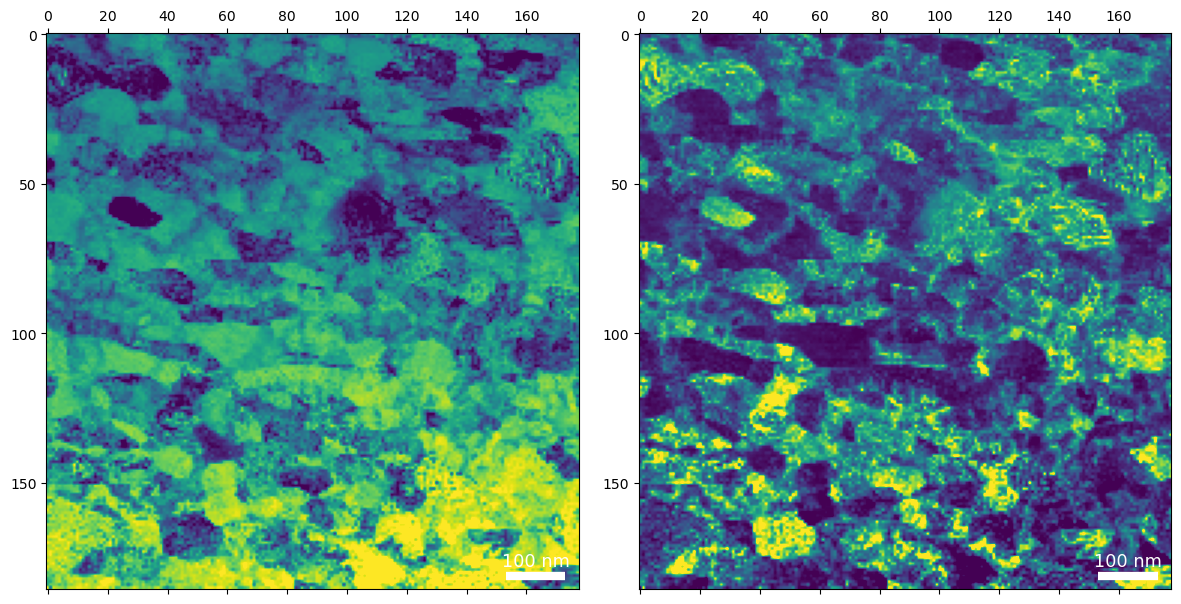

In [16]:
# virtual imaging - capture images

im_bf = datacube.get_virtual_image(
    mode = 'circle',
    geometry = (center,radius)
)
im_adf = datacube.get_virtual_image(
    mode = 'annulus',
    geometry = (center,(radius,radius*10))
)

show(
    [im_bf,im_adf],
    cmap = 'viridis'
)

# Find Bragg vectors

In [17]:
probe = basics_03.tree('probe')

probe

Probe( A stack of 2 Arrays with 2-dimensions and shape (512, 512), called 'probe'

       The labels are:
           probe
           kernel


       The Array dimensions are:
           dim0 = [0,1,2,...] pixels
           dim1 = [0,1,2,...] pixels
)

In [18]:
py4DSTEM.visualize.show_kernel(
    probe.kernel,
    R = 24,
    L = 24,
    W = 1
)

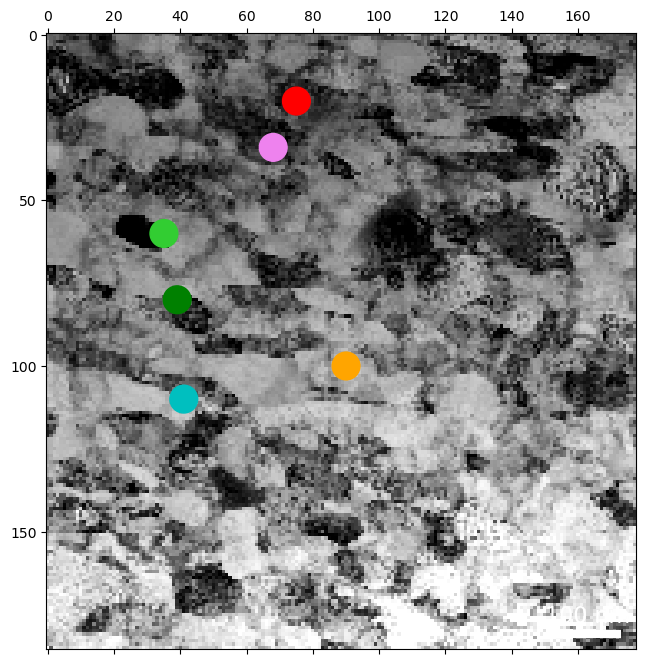

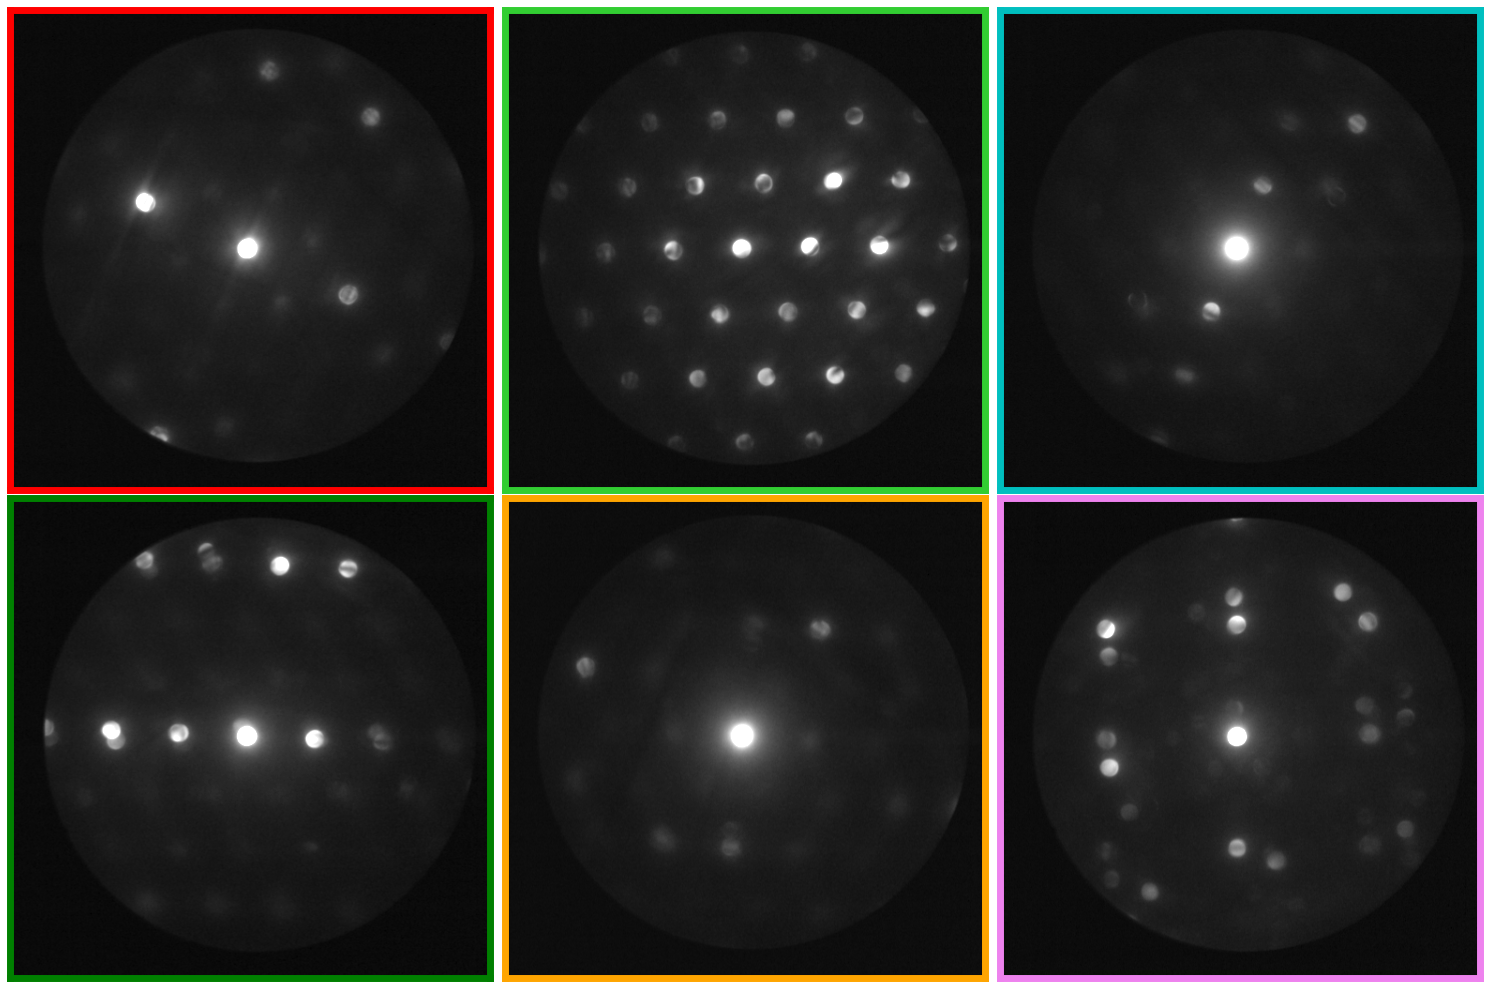

In [19]:
# Select a few sample patterns for parameter tuning


# choose scan positions

rxs = 20,60,110,80,100,34
rys = 75,35,41,39,90,68,



# visualize

colors=['r','limegreen','c','g','orange', 'violet']

# show the selected
# positions in real space
py4DSTEM.visualize.show_points(
    im_bf,
    x=rxs,
    y=rys,
    scale=400,
    pointcolor=colors,
    figsize=(8,8)
)

# show the selected
# diffraction patterns
py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:datacube[rxs[i],rys[i],:,:],
    H=2,W=3,
    axsize=(5,5),
    intensity_range='absolute',
    vmin=1,
    vmax=1e5,
    scaling='power',
    power=0.5,
    get_bordercolor = lambda i:colors[i],
)

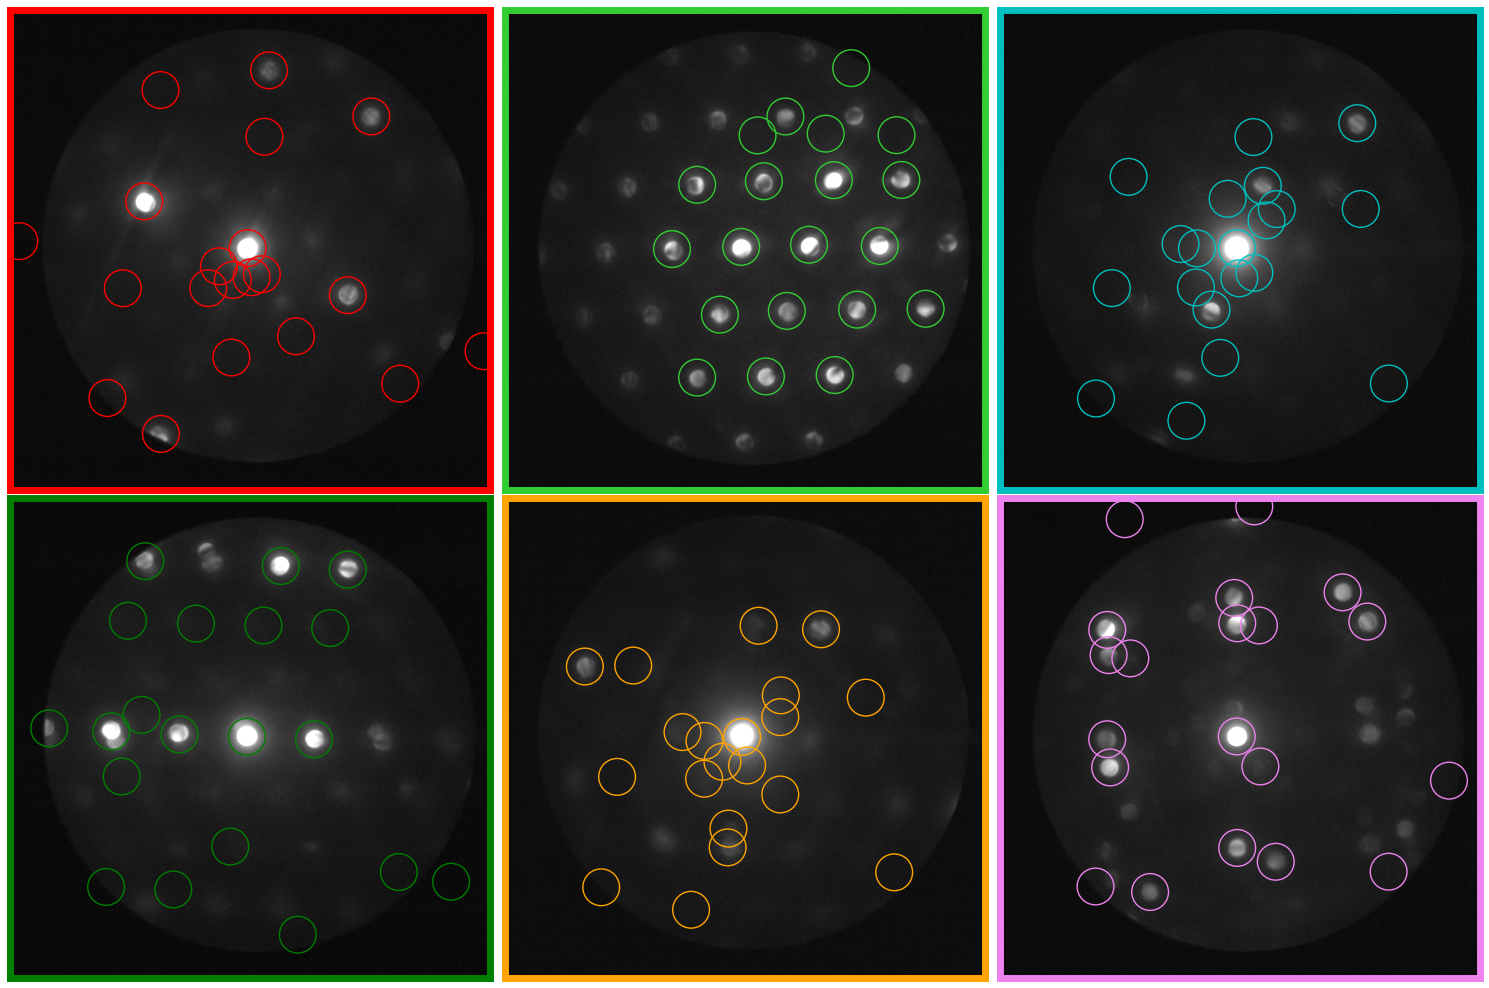

In [20]:
# Choose disk detection parameters


# set parameters

detect_params = {
    'minAbsoluteIntensity': 8,
    'minRelativeIntensity': 0,
    'minPeakSpacing': 11,
    'edgeBoundary': 2,
    'sigma': 0.4,
    'maxNumPeaks': 20,
    'subpixel' : 'poly',
    'corrPower': 1.0,
#     'CUDA': True,
}


# find disks for selected patterns
disks_selected = datacube.find_Bragg_disks(
    data = (rxs, rys),
    template = probe.kernel,
    **detect_params,
)

# show
py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:datacube[rxs[i],rys[i],:,:],
    H=2, 
    W=3,
    axsize=(5,5),
    intensity_range='absolute',
    vmin=1,
    vmax=1e5,
    scaling='power',
    power=0.5,
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 700,
)

In [21]:
# compute for all diffraction patterns

braggpeaks = datacube.find_Bragg_disks(
    template = probe.kernel,
    **detect_params,
)

Finding Bragg Disks: 100%|█████████████████████████████████████████| 33.1k/33.1k [11:57<00:00, 46.2DP/s]


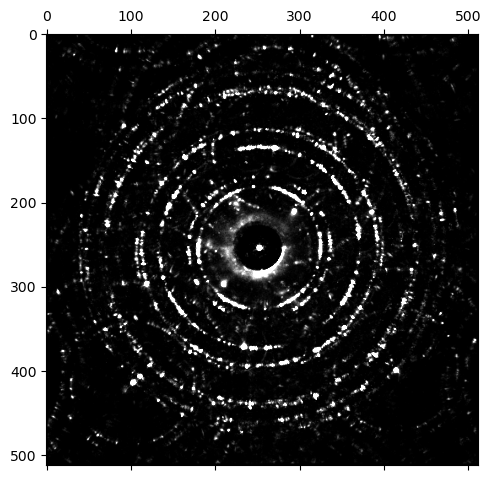

In [23]:
# Bragg vector map

# compute
bvm = braggpeaks.histogram( mode='raw' )

# show
show(bvm)


# Calibrate the origin

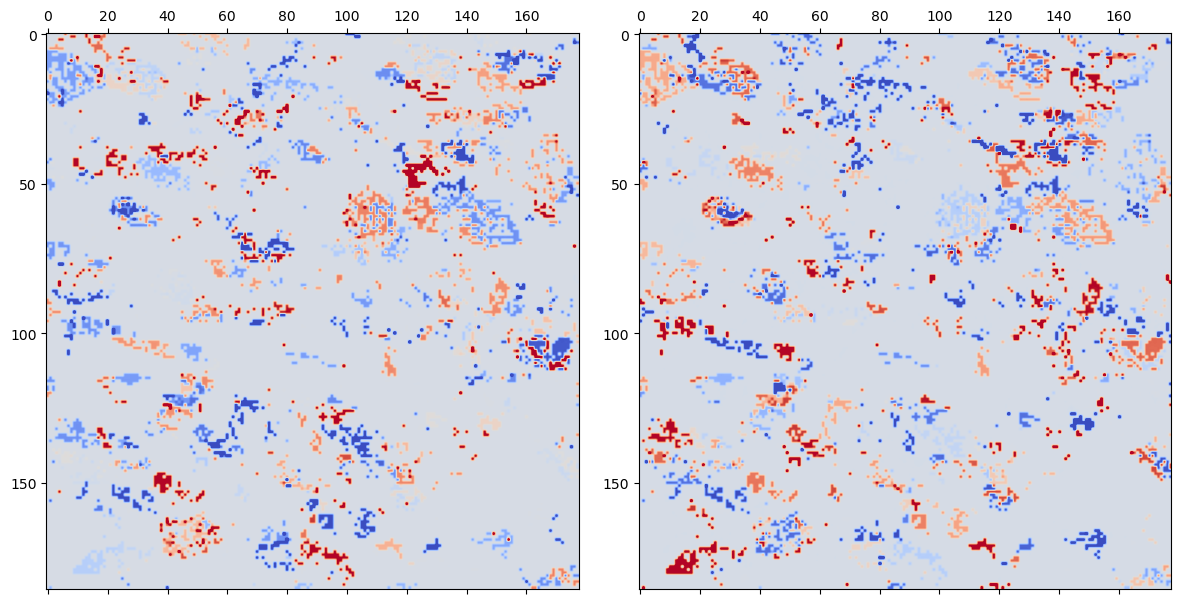

In [24]:
# Measure the origin

qx0_meas,qy0_meas,mask_meas = braggpeaks.measure_origin()

show(
    [qx0_meas,qy0_meas],
    cmap = 'coolwarm',
    mask = mask_meas
)


In [25]:
# Note that braggpeaks.measure_origin added its results to the Calibration metadata

braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:       0.005
             R_pixel_size:       5
             Q_pixel_units:      A^-1
             R_pixel_units:      nm
             QR_flip:            False
             _root_treepath:     
             a:                  586.6972915499178
             b:                  579.7485386887054
             theta:              -1.094329280203596
             qx0_meas:           2D-array
             qy0_meas:           2D-array
             origin_meas_mask:   2D-array
)

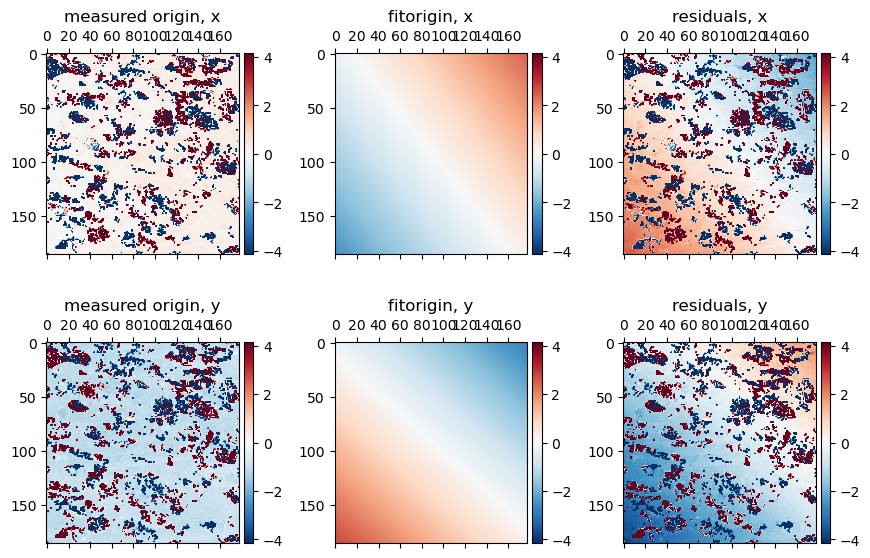

In [26]:
# Fit a plane to the origins

qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = braggpeaks.fit_origin()

In [27]:
# The fit origins now live in the calibration metadata as 'qx0','qy0'

braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:       0.005
             R_pixel_size:       5
             Q_pixel_units:      A^-1
             R_pixel_units:      nm
             QR_flip:            False
             _root_treepath:     
             a:                  586.6972915499178
             b:                  579.7485386887054
             theta:              -1.094329280203596
             qx0_meas:           2D-array
             qy0_meas:           2D-array
             origin_meas_mask:   2D-array
             qx0:                2D-array
             qx0_mean:           253.9385904004459
             qx0_shift:          2D-array
             qy0:                2D-array
             qy0_mean:           253.29710703002038
             qy0_shift:          2D-array
)

In [28]:
# The calibration state of our BraggVectors has automatically updated

braggpeaks.calstate

{'center': True, 'ellipse': True, 'pixel': True, 'rotate': False}

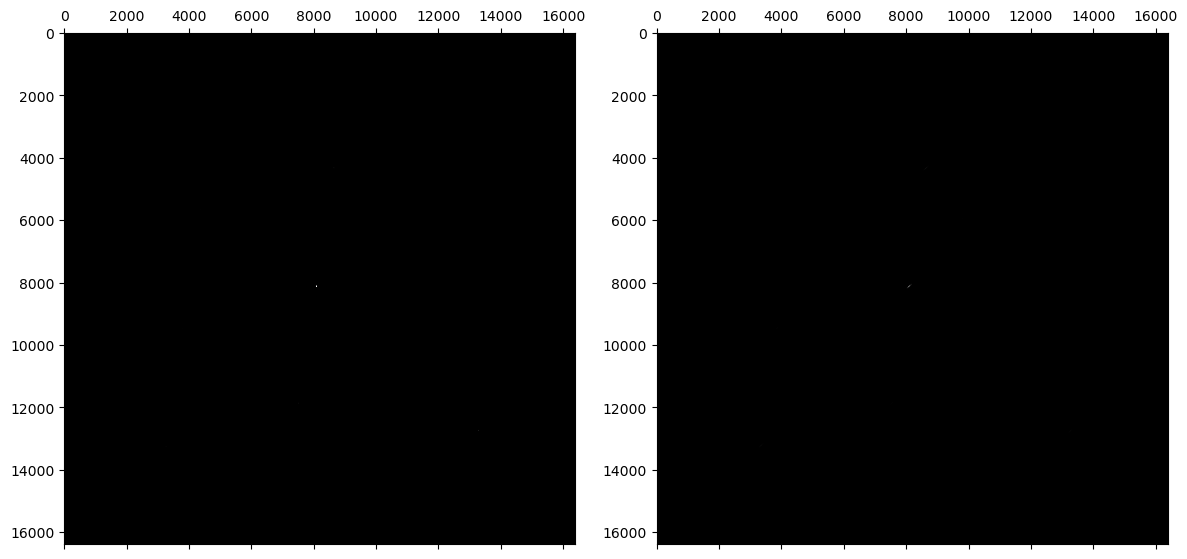

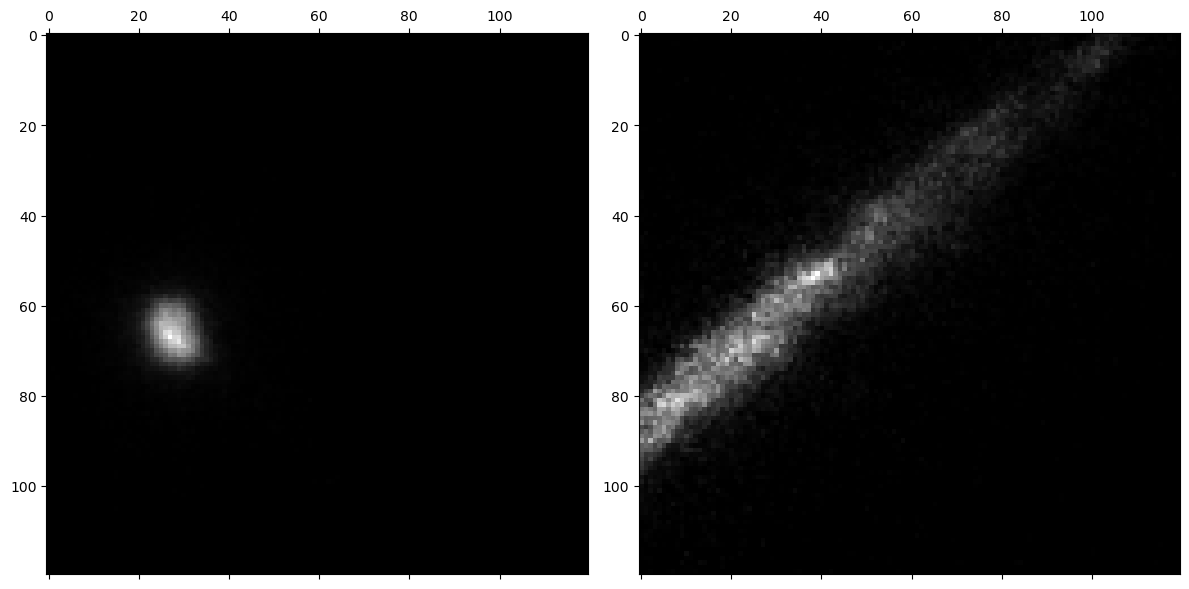

In [29]:
# Compare this to the uncalibrated BVM - much better!

# compute raw vs. centered
bvm_r = braggpeaks.histogram( mode='raw', sampling=32 )
bvm_c = braggpeaks.histogram( mode='cal', sampling=32 )

# show
show( [bvm_r, bvm_c] ,vmax=0.999999)

# show, zooming in on origin
L = 60
x,y = bvm_c.origin
import numpy as np
x0,xf = np.round([x-L,x+L]).astype(int)
y0,yf = np.round([y-L,y+L]).astype(int)

show(
    [
    bvm_r[x0:xf,y0:yf],
    bvm_c[x0:xf,y0:yf]
    ],
    vmax=0.999999
)

# Calibrate the rotation

In [30]:
# Compare a virtual image to the defocused CBED image

#show(
#   [im_bf,defocused_cbed]
#)

In [31]:
# # Find the QR rotation

QR_rotation = 0   # in degrees

# py4DSTEM.process.calibration.compare_QR_rotation(
#     im_bf,
#     defocused_cbed,
#     QR_rotation,
#     R_rotation = 158,
#     R_position = (59,16.5),
#     Q_position = (154,205),
#     R_pos_anchor = 'tail',
#     Q_pos_anchor = 'tail',
#     R_length = 0.4,
#     Q_length = 0.3,
#     #figsize = (10,5),
# )

In [32]:
# Set the rotation

braggpeaks.calibration.set_QR_rotation_degrees( QR_rotation )
braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:          0.005
             R_pixel_size:          5
             Q_pixel_units:         A^-1
             R_pixel_units:         nm
             QR_flip:               False
             _root_treepath:        
             a:                     586.6972915499178
             b:                     579.7485386887054
             theta:                 -1.094329280203596
             qx0_meas:              2D-array
             qy0_meas:              2D-array
             origin_meas_mask:      2D-array
             qx0:                   2D-array
             qx0_mean:              253.9385904004459
             qx0_shift:             2D-array
             qy0:                   2D-array
             qy0_mean:              253.29710703002038
             qy0_shift:             2D-array
             QR_rotation:           0.0
             QR_rotation_degrees:   0
)

# Strain mapping

In [33]:
strainmap = py4DSTEM.StrainMap( braggvectors=braggpeaks )

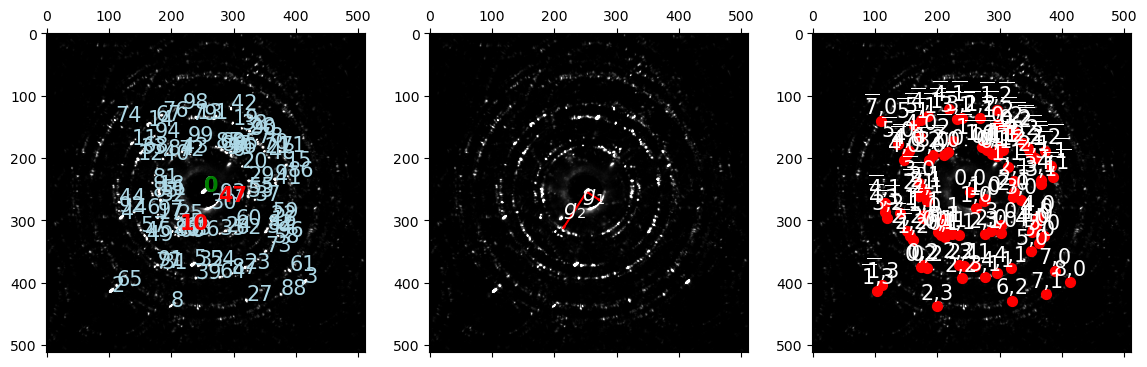

In [34]:
strainmap.choose_basis_vectors(
    minSpacing=4,
    minAbsoluteIntensity=3e3,
    maxNumPeaks=100,
    edgeBoundary=1,
    vis_params = {
        'vmin' : 0,
        'vmax' : 0.995
    }
)

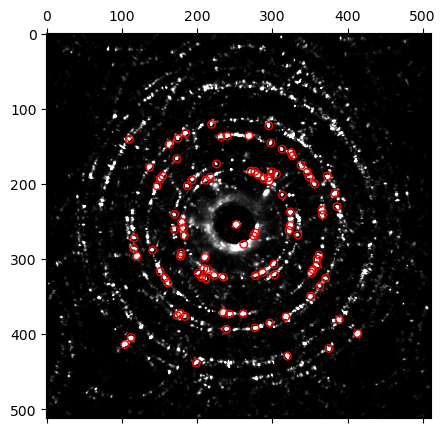

In [35]:
strainmap.set_max_peak_spacing(
    max_peak_spacing = 5
)

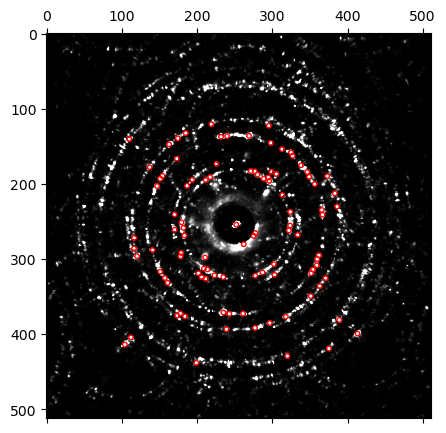

Indexing Bragg scattering: 100%|██████████████████████████████████| 33.1k/33.1k [00:12<00:00, 2.58kDP/s]
Fitting lattice vectors: 100%|████████████████████████████████████| 33.1k/33.1k [00:07<00:00, 4.38kDP/s]


In [36]:
strainmap.fit_basis_vectors(
    max_peak_spacing = 3
)

Calculating strain: 100%|█████████████████████████████████████████| 33.1k/33.1k [00:06<00:00, 4.89kDP/s]


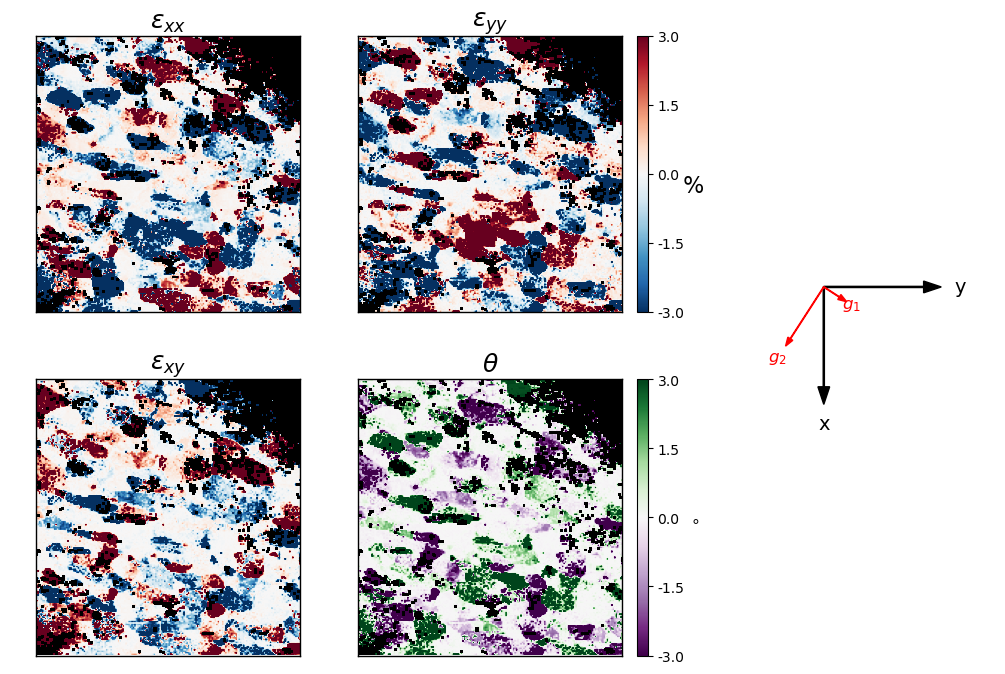

In [37]:
# strain map

strainmap.get_strain(
    gvects=None,
    coordinate_rotation=0,
    returncalc=False,
)

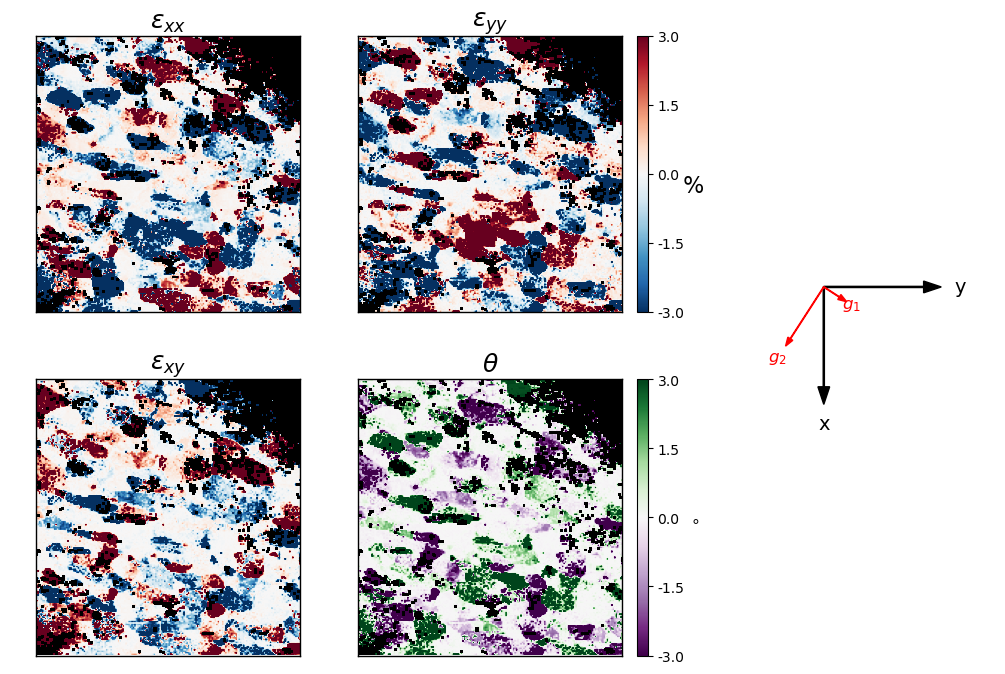

In [38]:
strainmap.show_strain(
    vrange=[-3, 3],
    vrange_theta=[-3, 3],
    vrange_exx=None,
    vrange_exy=None,
    vrange_eyy=None,
    show_cbars=None,
    bordercolor='k',
    borderwidth=1,
    titlesize=18,
    ticklabelsize=10,
    ticknumber=5,
    unitlabelsize=16,
    cmap='RdBu_r',
    cmap_theta='PRGn',
    mask_color='k',
    color_axes='k',
    show_legend=True,
    show_gvects=True,
    color_gvects='r',
    legend_camera_length=1.6,
    scale_gvects=0.6,
    layout='square',
    figsize=None,
    returnfig=False,
)

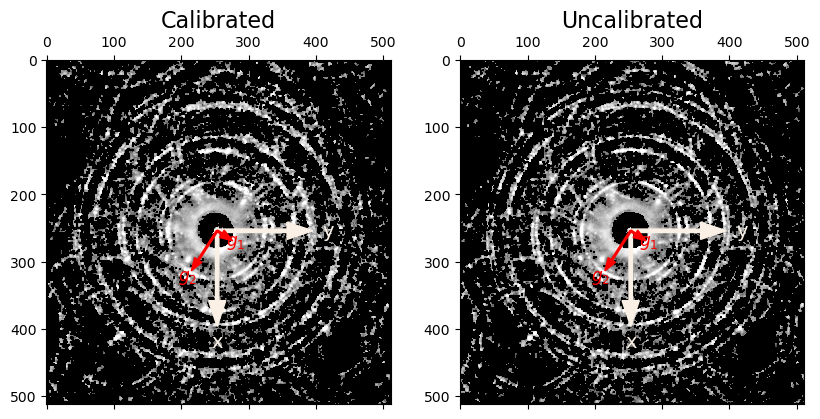

In [39]:
strainmap.show_reference_directions(
    im_uncal=None,
    im_cal=None,
    color_axes='linen',
    color_gvects='r',
    origin_uncal=None,
    origin_cal=None,
    camera_length=1.8,
    visp_uncal={'scaling': 'log'},
    visp_cal={'scaling': 'log'},
    layout='horizontal',
    titlesize=16,
    size_labels=14,
    figsize=None,
    returnfig=False,
)

# Strain using reference $g_1$ and $g_2$ from an ROI

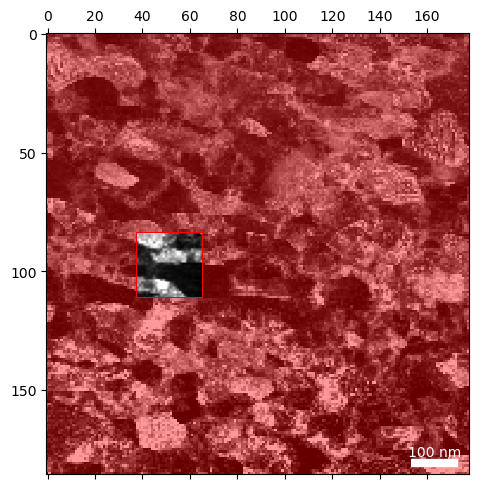

In [40]:
# Set reference region

ROI = np.zeros(braggpeaks.Rshape, dtype=bool)
ROI[84:112, 38:66] = True

show(
    im_adf,
    mask = ROI,
    mask_color='r',
    mask_alpha=0.6
)

Calculating strain: 100%|█████████████████████████████████████████| 33.1k/33.1k [00:07<00:00, 4.70kDP/s]


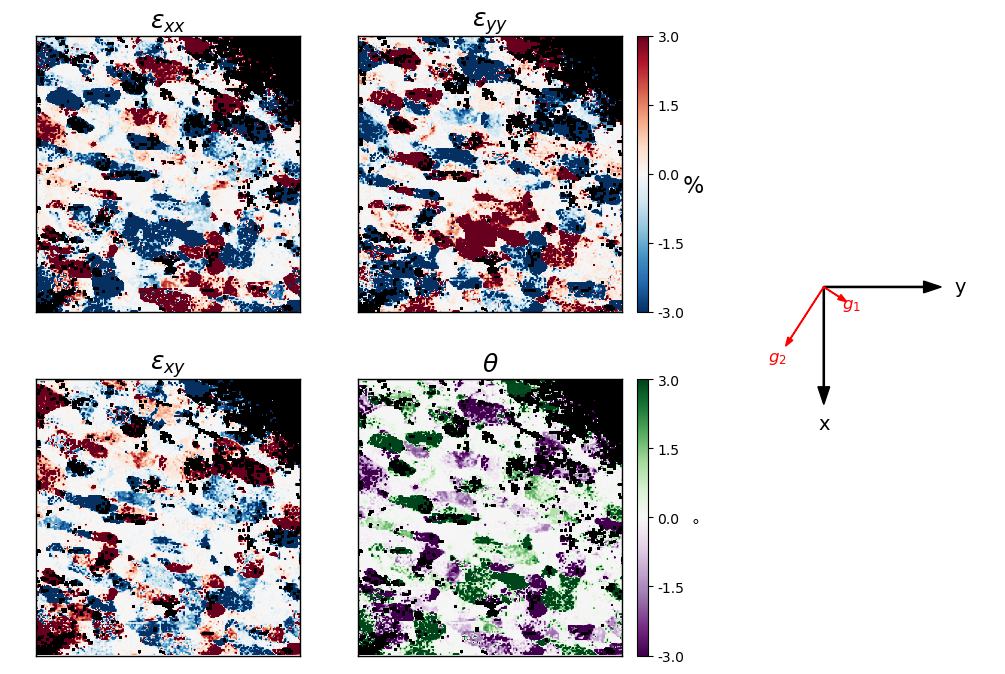

In [41]:
# strain from a region

strainmap.get_strain(
    gvects = ROI,
    coordinate_rotation=0,
    returncalc=False,
)

# Strain using a manually specified reference $g_1$ and $g_2$

Calculating strain: 100%|█████████████████████████████████████████| 33.1k/33.1k [00:07<00:00, 4.72kDP/s]


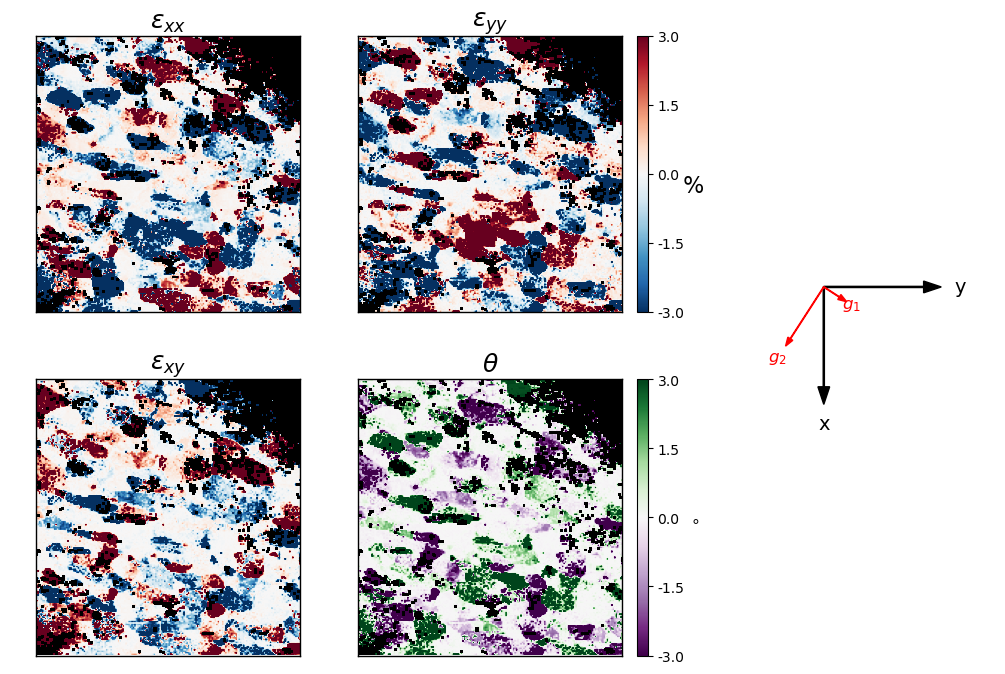

In [42]:
g1_ref, g2_ref = strainmap.get_reference_g1g2( ROI )

strainmap.get_strain(
    gvects=None,
    coordinate_rotation=0,
    returncalc=False
)